# Estimating power spectra

The  following exercise covers the  basics of how to calculate power spectra based on the Fast Fourier Transform (fft). In particular the pro and cons are addressed when calculating power spectra using windowing approaches such as Welch’s methods. We also discuss the application of Hanning tappers. 

Please go through the exercises step-by-step and answer the questions.

Note the plots are made to commands using '#' . Remove the '#' to show plots.

First import the relevant Python modules: 

In [456]:
import matplotlib.pyplot as plt
import numpy as np
from random import gauss

## The test signal

The sampling frequency is set to 2048 Hz:

In [457]:
Fs = 1024

The number of sampling points resulting in a 10 s long signal:

In [458]:
N = 10240

and the corresponding the time axis:

In [459]:
timeVec = np.arange(0, 10,1/Fs)

The following ordinary differential equations simulate the so-called Brusselator. This is a 
set of equations simulating a simple chemical system producing spontaneous oscillations. 
The aim is to produce oscillatory activity with phase and amplitude jitter. You do not 
need to understand the details but just appreciate the output.

In [460]:
x =  0; y  = 0;
A = 1; B = 4.0; dt = 100/Fs; 
k= 0; 
for t in timeVec:
    x += dt*(A + x*x*y - B*x-x) 
    y += dt*(B*x- x*x*y) 
    x += gauss(0,0.07) 
    s[k] = x
    k += 1

Add a sinusoidal signal to simulate the 50 Hz line noise: 

In [461]:
s += 0.2*np.sin(2*np.pi*50*timeVec)

Remove the mean (or 'DC shift'):

In [462]:
s -= np.mean(s,axis=0)

Plot the signal:

(3.0, 4.0)

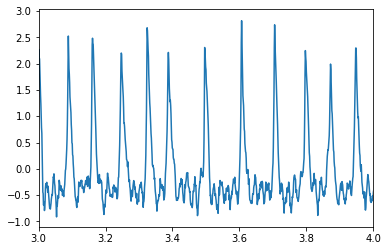

In [463]:
plt.plot(timeVec,s)
plt.xlim(3,4)

### Question 1:
 a) What is the approximate frequency of the oscillations in the signal?

 b) Can you observe the 50 Hz contribution?

## Calculating the power spectrum using FFT
Now perform the Fourier transform using the Fast-Fourier Transform algorithm and 
normalize it with respect to number of sampling points:

In [464]:
Sfft = np.fft.fft(s)/(N/2)

Use only us the first half (the other half is redundant):

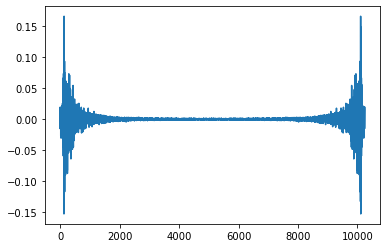

In [465]:
plt.plot(np.real(Sfft))

Calculate the frequency axis:

In [467]:
freqVec = (Fs/N)*np.arange(0, int(N))

Now plot the real and imaginary part of the Fourier transform (up to 60 Hz):

(-0.2, 0.2)

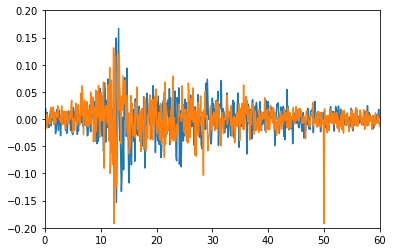

In [468]:
plt.plot(freqVec,np.real(Sfft), freqVec, np.imag(Sfft)) 
plt.xlim(0,60)
plt.ylim(-0.2,0.2)

### Question 2:
a) How can the phase of the individual Fourier components be derived from the real and 
imaginary values? 

b) Is the 50 Hz present?

The following step calculates the power spectrum by taking the absolute squared values 
of the complex Fourier representation:

In [469]:
P = np.real(Sfft) ** 2 + np.imag(Sfft) ** 2;

Plot the spectrum from 0 to 60 Hz:

(0.0, 60.0)

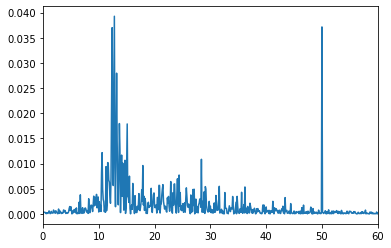

In [470]:
plt.plot(freqVec,P)
plt.xlim(0,60)

### Question 3:
a) What is the approximate frequency of the oscillations produced by the Brusselator?

b) What is the spectral width of the oscillations? 

c) The power of the 50 Hz line noise is about 0.04. Why this value?

d) What is the frequency resolution of the power spectrum?

e) How might the spectral estimate be improved?

f) Can you reconstruct the original signal from the power spectrum?

## Spectral estimation by windowing

In the following section the signal will be divided into short segments being 1 s long (N = 
1024 sample points). These windows will overlap by 50% (512 sample points), meaning 
that the 10 s will be segmented in 19 overlapping windows. 

In [471]:
Nwindow = 1024

Define the indices meaning the sampling points for the ‘start’ and the ‘stop’ of each time 
window  ( [1 1024], [513 1536], [1025 2048], ...): 

In [472]:
s_sub = np.zeros((19,1024))
for k in range(0,19):
    i_start = k*512
    i_stop = k*512+Nwindow
    s_sub[k][:] = s[i_start:i_stop]

Note that the rows contain the 19 segments and the columns the 1024 data points:

In [473]:
print(s_sub.shape)

(19, 1024)


Plot for instance segment 3:

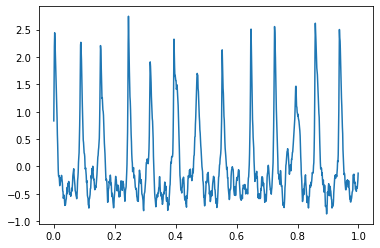

In [474]:
plt.plot(np.arange(0, Nwindow)/Fs,s_sub[3][:]) 

Calculate the fft for each segment and subsequently the power: 

In [475]:
Sfft = np.zeros((19,1024),dtype=complex)
for k in range(0,19):
    Sfft[k][:] = np.fft.fft(s_sub[k][:])/(Nwindow/2)


In [476]:
P = np.real(Sfft) ** 2 + np.imag(Sfft) ** 2;

Now calculate the frequency axis for 1024 sample points and plot the result for segment 3:

(0.0, 60.0)

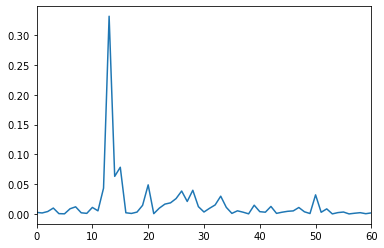

In [477]:
freqVec = (Fs/Nwindow)*np.arange(0, int(Nwindow/2),1)
plt.plot(freqVec,P[3][0:int(Nwindow/2)])
plt.xlim(0,60)

### Question 4:
What is the frequency resolution of the new power spectrum? Which peaks in the 
spectrum can you trust?

Now calculate the mean of the 19 spectra and plot the results:

(0.0, 60.0)

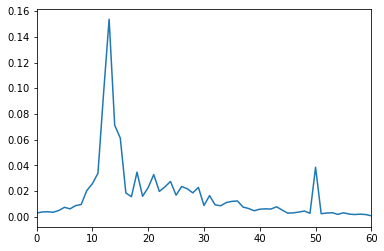

In [478]:
freqVec = (Fs/Nwindow)*np.arange(0, int(Nwindow),1)
plt.plot(np.mean(P,axis=0))
plt.xlim(0,60)

### Question 5:
a) Show the plot

b) What peaks can you consider reliable?

b) Compare to the first power spectrum (calculated for N=10240 without windowing). In what sense is the spectrum improved? And in what sense is it worsened? 

c) How could the power spectrum estimate be further smoothed?

## Using Hanning tapers
The power spectrum estimate can be further improved using tapers. In the following case 
we have chosen for the Hanning taper. Calculate it for a 1024 long window and plot:

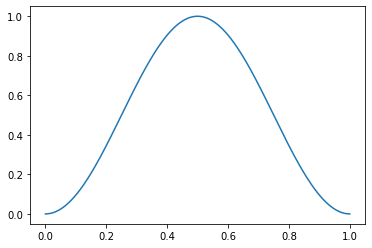

In [479]:
taper = np.hanning(Nwindow)#
plt.plot(np.arange(0, Nwindow)/Fs,  taper)

Apply the taper to the 3rd time window and plot the results before and after:

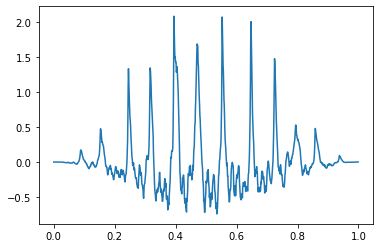

In [480]:
plt.plot(np.arange(0, Nwindow)/Fs,taper * s_sub[3][:]) 

### Question 6:
a) Why is this function termed a ‘taper’?

b) Why might this operation be useful?

Now apply the taper to all the 19 segments and calculate the respective power spectra.

In [481]:
for k in range(0,19):
    Sfft[k][:] = np.fft.fft(taper*s_sub[k][:])/(Nwindow/2)
    
P = np.real(Sfft) ** 2 + np.imag(Sfft) ** 2;   

Plot the averaged power spectra:

(0.0, 60.0)

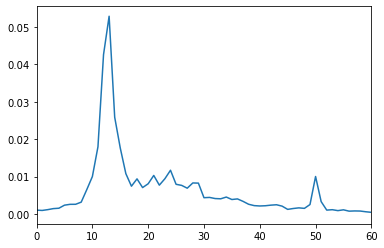

In [482]:
plt.plot(freqVec,np.mean(P,axis=0))
plt.xlim(0,60)

### Question 7:
a) What is the consequence of applying a taper? (consider both the slower oscillations 
and the 50 Hz peak)

b) Why did we choose a window with 50% overlap rather than no overlap?